In [1]:
using Flux, Plots
using ChainRulesCore
using Statistics
using Random
#using Distributions
using MDToolbox
using CUDA
using BenchmarkTools
using EzXML

ENV["COLUMNS"] = 130

130

In [2]:
@show collect(devices())
@show device!(1)
@show device()

collect(devices()) = CuDevice[CuDevice(0), CuDevice(1)]
device!(1) = CuDevice(1)
device() = CuDevice(1)


CuDevice(1): Quadro RTX 8000

In [3]:
pdb_filepath = "./alanine-dipeptide-nowater.pdb"
traj_dir = "./traj"
ff_dir = "./forcefield"
njobs = 7

target_traj_path = "./traj/traj8.dcd"
target_ff_filepath = "./forcefield/sim_8.xml"

"./forcefield/sim_8.xml"

In [4]:
#pythonのmdtrajのインデックスに+1してる
atom_pairs = [6 17]           #距離を計算する原子のペア
phi_indices = [5, 7, 9, 15]   #二面角ϕ
psi_indices = [7, 9, 15, 17]  #二面角ψ

#xmlファイルでのatom type
phi_atom_type = ["C", "N", "CT", "C"]
psi_atom_type = ["N", "CT", "C", "N"]

4-element Vector{String}:
 "N"
 "CT"
 "C"
 "N"

In [5]:
top = readpdb(pdb_filepath)
ta = mdload(target_traj_path, top=top)

for i in 1:length(top.atomid)
    println("atomid = $(top.atomid[i]), atomname = $(top.atomname[i])")
end
println()
#sanity check
@show ta[:,vec(atom_pairs)].atomname
@show ta[:, phi_indices].atomname
@show ta[:, psi_indices].atomname

atomid = 1, atomname = HH31
atomid = 2, atomname = CH3
atomid = 3, atomname = HH32
atomid = 4, atomname = HH33
atomid = 5, atomname = C
atomid = 6, atomname = O
atomid = 7, atomname = N
atomid = 8, atomname = H
atomid = 9, atomname = CA
atomid = 10, atomname = HA
atomid = 11, atomname = CB
atomid = 12, atomname = HB1
atomid = 13, atomname = HB2
atomid = 14, atomname = HB3
atomid = 15, atomname = C
atomid = 16, atomname = O
atomid = 17, atomname = N
atomid = 18, atomname = H
atomid = 19, atomname = CH3
atomid = 20, atomname = HH31
atomid = 21, atomname = HH32
atomid = 22, atomname = HH33

(ta[:, vec(atom_pairs)]).atomname = ["O", "N"]
(ta[:, phi_indices]).atomname = ["C", "N", "CA", "C"]
(ta[:, psi_indices]).atomname = ["N", "CA", "C", "N"]


4-element Vector{String}:
 "N"
 "CA"
 "C"
 "N"

## input target traj

In [6]:
phi = compute_dihedral(ta[:,phi_indices[1]], ta[:,phi_indices[2]], ta[:,phi_indices[3]], ta[:,phi_indices[4]]) * π / 180
psi = compute_dihedral(ta[:,psi_indices[1]], ta[:,psi_indices[2]], ta[:,psi_indices[3]], ta[:,psi_indices[4]]) * π / 180
dihedral_target = hcat(phi, psi)
distance_target = compute_distance(ta, atom_pairs) ./ 10

100000×1 Matrix{Float64}:
 0.4557272880032969
 0.3969620583928402
 0.40588421074375114
 0.45621472385467204
 0.3968975288671349
 0.41259354688401484
 0.4082375838915252
 0.404707033552233
 0.48863684289583753
 0.4152569827392904
 0.445251529434913
 0.3759139012473771
 0.37227408007451934
 ⋮
 0.40446336908483016
 0.5050478534369355
 0.3851853285293964
 0.4160895075690319
 0.3958587682847585
 0.4116100352112199
 0.4440289623113752
 0.398664211967022
 0.47490291274157925
 0.3893070333917464
 0.4591289142820673
 0.4492650034805128

## input traj

In [7]:
dihedral_k = Array{Array{Float32}}(undef, njobs)
distance_k = Array{Array{Float32}}(undef, njobs)

for i in 1:njobs
    traj_filepath = joinpath(traj_dir, "traj$(i).dcd")
    ta = mdload(traj_filepath, top=top)

    phi = compute_dihedral(ta[:,phi_indices[1]], ta[:,phi_indices[2]], ta[:,phi_indices[3]], ta[:,phi_indices[4]]) * π / 180
    psi = compute_dihedral(ta[:,psi_indices[1]], ta[:,psi_indices[2]], ta[:,psi_indices[3]], ta[:,psi_indices[4]]) * π / 180
    dihedral_k[i] = hcat(phi, psi)
    
    distance = compute_distance(ta, atom_pairs) ./ 10 #おそらくこれでnmに変換してる
    distance_k[i] = distance
end

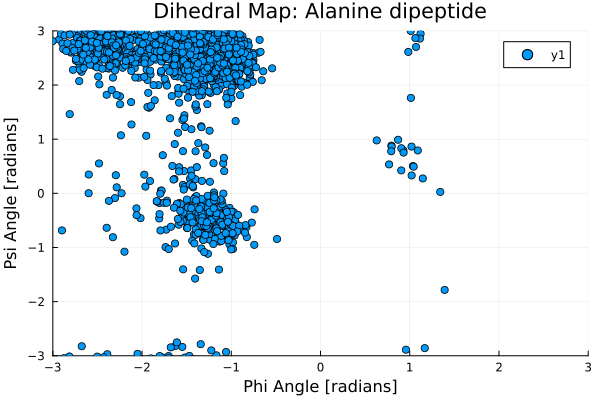

In [8]:
plot(dihedral_target[1:50:end, 1], dihedral_target[1:50:end, 2], st=scatter,
    xlabel="Phi Angle [radians]", ylabel="Psi Angle [radians]", title=("Dihedral Map: Alanine dipeptide"),
    xlim=(-3,3),ylim=(-3,3))

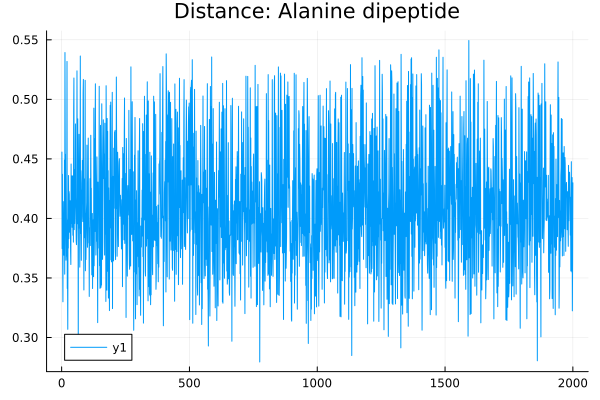

In [9]:
plot(distance_target[1:50:end], title="Distance: Alanine dipeptide")

## input forcefield parameter

In [10]:
#二面角ϕ,ψに関連するパラメータはn,θ₀,kの３つ
#最適化を目指すのはk

abstract type AbstractParam end

struct ParamCPU<:AbstractParam
    n::Vector{Float32}
    theta_zero::Vector{Float32}
    k::Vector{Float32}
end

struct Param<:AbstractParam
    n::CuArray{Float32}
    theta_zero::CuArray{Float32}
    k::CuArray{Float32}
end

function init_Param(ff_array::AbstractVector, gpu=false::Bool)
    n = Float32[]
    theta_zero = Float32[]
    k = Float32[]
    
    for line in ff_array
        #println(line)      
        if(occursin(r"type.*", line[1]))
            continue
        elseif(occursin(r"periodicity.*", line[1]))
            push!(n, parse(Float32, line[2]))
        elseif(occursin(r"phase.*", line[1]))
            push!(theta_zero, parse(Float32, line[2]))
        elseif(occursin(r"k.*", line[1]))
            push!(k, parse(Float32, line[2]))
        else
            println("ERROR")
        end
    end
    
    if(gpu)
        n = CUDA.cu(n)
        theta_zero = CUDA.cu(theta_zero)
        k = CUDA.cu(k)
        ff_param = Param(n, theta_zero, k)
        return ff_param
    end
    
    ff_param = ParamCPU(n, theta_zero, k)
    return ff_param
end

init_Param (generic function with 2 methods)

In [11]:
#力場ファイルから対象のパラメータを返す関数
function input_ff(ff_filepath; gpu=false::Bool)
    xml = readxml(ff_filepath)
    xmlroot = root(xml)
    
    children = elements(xmlroot)
    children_name = nodename.(children)
    torsion_index = children_name .== "PeriodicTorsionForce"
    torsion = children[torsion_index][1]
    
    phi_atom_type = ["C", "N", "CT", "C"]
    psi_atom_type = ["N", "CT", "C", "N"]
    
    ff_phi = []
    ff_psi = []
    for ff_params in eachelement(torsion)
        params_name = [nodename(i) for i in eachattribute(ff_params)]
        params_content = [nodecontent(i) for i in eachattribute(ff_params)]
        #println(params_content[1:4])
        if(params_content[1:4] == phi_atom_type)
            ff_phi = [(params_name[i], params_content[i]) for i in 1:length(params_name)]
        end
        if(params_content[1:4] == psi_atom_type)
            ff_psi = [(params_name[i], params_content[i]) for i in 1:length(params_name)]
        end
    end

    return init_Param(ff_phi, gpu), init_Param(ff_psi, gpu)
end

input_ff (generic function with 1 method)

In [12]:
ff_phi_k = Array{ParamCPU}(undef, njobs)
ff_psi_k = Array{ParamCPU}(undef, njobs)

for i in 1:njobs
    ff_filepath = joinpath(ff_dir, "sim_$(i).xml")
    ff_phi_k[i], ff_psi_k[i] = input_ff(ff_filepath)
end

#input target ff
ff_phi_target, ff_psi_target = input_ff(target_ff_filepath, gpu=true)

(Param(Float32[1.0, 2.0, 3.0, 4.0, 2.0], Float32[0.0, 0.0, 0.0, 0.0, 1.5707964], Float32[-0.14163189, 1.4679414, 2.2578616, 0.3232448, 1.5995961]), Param(Float32[1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 1.0, 2.0, 3.0, 4.0, 5.0], Float32[2.808034, 3.1415927, 3.1415927, 3.1415927, 3.1415927, 3.1415927, 1.5707964, 1.5707964, 1.5707964, 1.5707964, 1.5707964], Float32[2.635137, -0.8166651, 5.976335, 2.0119128, -0.07485608, -0.015644075, -1.043114, 0.29952207, 0.22971323, 0.10157014, -0.045043305]))

In [13]:
#二面角のポテンシャルの計算
@inline function compute_dihedral_energy(theta::AbstractFloat, n::AbstractFloat, theta_zero::AbstractFloat, k::AbstractFloat)
    return k * (1 + cos(n * theta - theta_zero))
end

function sum_compute_dihedral_energy(theta::AbstractFloat, ff_param::AbstractParam)
    return sum(compute_dihedral_energy.(theta, ff_param.n, ff_param.theta_zero, ff_param.k))
end

sum_compute_dihedral_energy (generic function with 1 method)

In [14]:
#compute u_kl
K = njobs
N_k = Array{Int}(undef, K)
for k in 1:K
    N_k[k] = length(distance_k[k])
end
T = 300.0
beta = Float32(1.0/T/8.314*1000.0)

u_kl = Array{Array{Float32}}(undef, (K, K))
for k in 1:K
    for l in 1:K
        u_kl[k, l] = map(i -> beta * sum_compute_dihedral_energy(dihedral_k[k][i, 1], ff_phi_k[l]) 
            + beta * sum_compute_dihedral_energy(dihedral_k[k][i, 2], ff_psi_k[l]), 1:N_k[k])
    end
end

In [15]:
f_k = Float32.(MDToolbox.mbar(u_kl))

iteration = 1  delta = 1.515951e+00  tol = 1.000000e-08
free energies =  0.000000 0.059623 0.070893 0.055245 -0.014015 0.074495 -0.050714

iteration = 2  delta = 1.476724e-03  tol = 1.000000e-08
free energies =  0.000000 0.059695 0.070939 0.055175 -0.014017 0.074549 -0.050765

iteration = 3  delta = 3.834489e-06  tol = 1.000000e-08
free energies =  0.000000 0.059695 0.070939 0.055175 -0.014017 0.074549 -0.050765

iteration = 4  delta = 8.953209e-09  tol = 1.000000e-08
free energies =  0.000000 0.059695 0.070939 0.055175 -0.014017 0.074549 -0.050765

iteration = 5  delta = 2.073623e-11  tol = 1.000000e-08
free energies =  0.000000 0.059695 0.070939 0.055175 -0.014017 0.074549 -0.050765

iteration = 6  delta = 3.612583e-14  tol = 1.000000e-08
free energies =  0.000000 0.059695 0.070939 0.055175 -0.014017 0.074549 -0.050765

iteration = 7  delta = 0.000000e+00  tol = 1.000000e-08
free energies =  0.000000 0.059695 0.070939 0.055175 -0.014017 0.074549 -0.050765

iteration = 8  delta = 0.00

7-element Vector{Float32}:
  0.0
  0.05969539
  0.0709388
  0.055174958
 -0.014017222
  0.07454898
 -0.050764836

## send from the CPU to the GPU

In [16]:
dihedral_k = dihedral_k |> Flux.gpu
distance_k = distance_k |> Flux.gpu
dihedral_target = dihedral_target |> Flux.gpu
distance_target = distance_target |> Flux.gpu

u_kl = u_kl |> Flux.gpu

function send_gpu_param(ff_param::AbstractParam)
    if(typeof(ff_param) == Param)
        return ff_param
    end
    ff_param_gpu = Param(CUDA.cu(ff_param.n), CUDA.cu(ff_param.theta_zero), CUDA.cu(ff_param.k))
    return ff_param_gpu
end

ff_phi_k = map(send_gpu_param, ff_phi_k)
ff_psi_k = map(send_gpu_param, ff_psi_k)

ff_phi_target = send_gpu_param(ff_phi_target)
ff_psi_target = send_gpu_param(ff_psi_target)

Param(Float32[1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 1.0, 2.0, 3.0, 4.0, 5.0], Float32[2.808034, 3.1415927, 3.1415927, 3.1415927, 3.1415927, 3.1415927, 1.5707964, 1.5707964, 1.5707964, 1.5707964, 1.5707964], Float32[2.635137, -0.8166651, 5.976335, 2.0119128, -0.07485608, -0.015644075, -1.043114, 0.29952207, 0.22971323, 0.10157014, -0.045043305])

## GPU kernel

In [17]:
#u_kを計算するための関数
function compute_u_kernel!(beta::Float32, dihedral::CuDeviceArray{T}, 
        n_phi::CuDeviceArray{T}, theta_zero_phi::CuDeviceArray{T}, k_phi::CuDeviceArray{T}, 
        n_psi::CuDeviceArray{T}, theta_zero_psi::CuDeviceArray{T}, k_psi::CuDeviceArray{T}, u::CuDeviceArray{T}) where {T}
    
    N = size(dihedral, 1)
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x

    phi_param_num = length(k_phi)
    psi_param_num = length(k_psi)

    for i in index:stride:N
        for j in 1:phi_param_num
            u[i] += beta * compute_dihedral_energy(dihedral[i, 1], n_phi[j], theta_zero_phi[j], k_phi[j])
        end
        for j in 1:psi_param_num
            u[i] += beta * compute_dihedral_energy(dihedral[i, 2], n_psi[j], theta_zero_psi[j], k_psi[j])
        end
    end

    return nothing
end

function compute_u_k(beta::Float32, dihedral_k::Vector{<:CuArray{T}},
        n_phi::CuArray{T}, theta_zero_phi::CuArray{T}, k_phi::CuArray{T}, 
        n_psi::CuArray{T}, theta_zero_psi::CuArray{T}, k_psi::CuArray{T}) where {T}
    K = length(dihedral_k)
    N_k = Array{Int}(undef, K)
    for k in 1:K
        N_k[k] = size(dihedral_k[k], 1)
    end

    u_k = Vector{CuArray{Float32}}(undef, K)
    
    for k in 1:K
        nthreads = 256
        nblocks = ceil(Int, N_k[k] / nthreads)

        u_k[k] = CUDA.cu(zeros(N_k[k]))
        @cuda threads=nthreads blocks=nblocks compute_u_kernel!(beta, dihedral_k[k], n_phi, theta_zero_phi, 
            k_phi, n_psi, theta_zero_psi, k_psi, u_k[k])
    end
    return u_k
end

function ChainRulesCore.rrule(::typeof(compute_u_k), beta::Float32, dihedral_k::Vector{<:CuArray{T}}, 
        n_phi::CuArray{T}, theta_zero_phi::CuArray{T}, k_phi::CuArray{T}, 
        n_psi::CuArray{T}, theta_zero_psi::CuArray{T}, k_psi::CuArray{T}) where {T}
    
    K = size(dihedral_k, 1)
    N_k = Array{Int}(undef, K)
    for k in 1:K
        N_k[k] = size(dihedral_k[k], 1)
    end

    u_k = Vector{CuArray{Float32}}(undef, K)
    
    for k in 1:K
        nthreads = 256
        nblocks = ceil(Int, N_k[k] / nthreads)

        u_k[k] = CUDA.cu(zeros(N_k[k]))
        @cuda threads=nthreads blocks=nblocks compute_u_kernel!(beta, dihedral_k[k], n_phi, theta_zero_phi, 
            k_phi, n_psi, theta_zero_psi, k_psi, u_k[k])
    end
    function compute_u_k_pullback(dU)
        dk_phi = similar(k_phi)
        dk_phi .= zero(Float32)
        dk_psi = similar(k_psi)
        dk_psi .= zero(Float32)
        
        for k = 1:K
            nthreads = 256
            nblocks = ceil(Int, N_k[k] / nthreads)
            @cuda threads=nthreads blocks=nblocks compute_u_pullback_aux!(dihedral_k[k], n_phi, theta_zero_phi, 
                n_psi, theta_zero_psi, dk_phi, dk_psi, dU[k])
        end
        return NoTangent(), NoTangent(), NoTangent(),
            NoTangent(), NoTangent(), dk_phi, NoTangent(), NoTangent(), dk_psi, NoTangent()
    end
    return u_k, compute_u_k_pullback
end

function compute_u_pullback_aux!(dihedral::CuDeviceArray{U}, n_phi::CuDeviceArray{T}, theta_zero_phi::CuDeviceArray{T},
        n_psi::CuDeviceArray{T}, theta_zero_psi::CuDeviceArray{T}, 
        dk_phi::CuDeviceArray{T}, dk_psi::CuDeviceArray{T}, dU::CuDeviceArray{T}) where {T, U}
    
    N = size(dihedral, 1)

    phi_param_num = length(n_phi)
    psi_param_num = length(n_psi)

    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x
    
    for i in index:stride:N
        for j in 1:phi_param_num
            dk_phi[j] += (1.0 + cos(n_phi[j] * dihedral[i, 1] - theta_zero_phi[j])) * dU[i]
        end
        for j in 1:psi_param_num
            dk_psi[j] += (1.0 + cos(n_psi[j] * dihedral[i, 2] - theta_zero_psi[j])) * dU[i]
        end
    end
    return nothing
end

compute_u_pullback_aux! (generic function with 1 method)

In [18]:
#w_kを計算する関数
function mbar_weight_gpu(u_kl::AbstractArray{<:CuArray{T}}, f_k::AbstractArray{T}, u_k::AbstractArray{<:CuArray{T}}=nothing) where {T}
    K, L = size(u_kl)

    # N_k: number of data in k-th umbrella window
    N_k = zeros(Int64, K)
    for k = 1:K
        N_k[k] = length(u_kl[k, 1])
    end
    N_max = maximum(N_k)
    
    # conversion from array of array (u_kl) to array (u_kln)
    u_kln = CUDA.cu(zeros(Float32, K, K, N_max))
    for k = 1:K
        for l = 1:K
            u_kln[k, l, 1:N_k[k]] .= u_kl[k, l]
        end
    end
    
    u_kn = CUDA.cu(zeros(Float32, K, N_max))
    for k = 1:K
        if u_k === nothing
            u_kn[1, 1:N_k[k]] .= CUDA.cu(zero(Float32))
        else
            u_kn[k, 1:N_k[k]] .= u_k[k]
        end
    end
    
    log_w_kn = CUDA.cu(zeros(Float32, K, N_max))
    for k = 1:K
        log_w_kn[k, 1:N_k[k]] .= 1.0
    end
    idx = log_w_kn .> 0.5
    
    log_w_kn = mbar_log_wi_jn_gpu(N_k, f_k, u_kln, u_kn, K, N_max)
    log_w_n  = log_w_kn[idx]

    s = MDToolbox.logsumexp_1d(log_w_n)
    w_k = Vector{CuArray{Float32}}(undef, K)
    for k = 1:K
        w_k[k] = exp.((log_w_kn[k, 1:N_k[k]] .- s))
    end

    return w_k
end

function ChainRulesCore.rrule(::typeof(mbar_weight_gpu), 
        u_kl::AbstractArray{<:CuArray{T}}, f_k::AbstractArray{T}, u_k::AbstractArray{<:CuArray{T}}) where {T}
    w_k = mbar_weight_gpu(u_kl, f_k, u_k)
    K = size(u_kl, 1)
    du_k = deepcopy(w_k)
    N = length(w_k[1])
    nthreads = 1
    #nthreads = 256
    nblocks = ceil(Int, N / nthreads)
    function mbar_weight_gpu_pullback(dw_k)
        for k = 1:K
            @cuda threads=nthreads blocks=nblocks mbar_weight_pullback_aux!(w_k[k], dw_k[k], du_k[k])
        end
        return NoTangent(), ZeroTangent(), NoTangent(), du_k
    end
    return w_k, mbar_weight_gpu_pullback
end

function mbar_weight_pullback_aux!(w::CuDeviceArray{T}, dw::CuDeviceArray{T}, du::CuDeviceArray{T}) where {T}
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x

    N = length(w)
    for i = index:stride:N
        du[i] = dw[i] * (-w[i])
    end

    return nothing
end

mbar_weight_pullback_aux! (generic function with 1 method)

In [19]:
function mbar_log_wi_jn_gpu(N_k::AbstractArray{U}, f_k::AbstractArray{T}, 
        u_kln::CuArray{T}, u_kn::CuArray{T}, K::Int64, N_max::Int64) where {T, U}
    log_wi_jn = CUDA.cu(zeros(Float32, (K, N_max)))
    for k = 1:K
        tmp = CUDA.cu(repeat(log.(N_k), 1, N_k[k]) .+ repeat(f_k, 1, N_k[k]))
        x = tmp .- (u_kln[k, :, 1:N_k[k]] .- repeat(u_kn[k:k, 1:N_k[k]], K, 1))
        log_wi_jn[k:k, 1:N_k[k]] .= - MDToolbox.logsumexp_over_row(x)
    end
    return log_wi_jn
end

mbar_log_wi_jn_gpu (generic function with 1 method)

In [20]:
CUDA.@allowscalar(false)
u_k = compute_u_k(beta, dihedral_k, 
    ff_phi_target.n, ff_phi_target.theta_zero, ff_phi_target.k,
    ff_psi_target.n, ff_psi_target.theta_zero, ff_psi_target.k)

w_k = mbar_weight_gpu(u_kl, f_k, u_k)

7-element Vector{CuArray{Float32}}:
 Float32[1.4398322f-6, 1.4927276f-6, 1.4351041f-6, 1.4163597f-6, 1.4475132f-6, 1.5203409f-6, 1.3734508f-6, 1.4572116f-6, 1.4121921f-6, 1.40033f-6  …  1.4327875f-6, 1.4000643f-6, 1.4514336f-6, 1.4198232f-6, 1.532923f-6, 1.4378604f-6, 1.4829612f-6, 1.4602819f-6, 1.5029151f-6, 1.4344527f-6]
 Float32[1.5068848f-6, 1.4562308f-6, 1.4164732f-6, 1.4354696f-6, 1.4533603f-6, 1.4496974f-6, 1.4084529f-6, 1.4625509f-6, 1.4465859f-6, 1.4887099f-6  …  1.3915927f-6, 1.4343118f-6, 1.4568282f-6, 1.4233589f-6, 1.5288088f-6, 1.3992474f-6, 1.4024175f-6, 1.4001043f-6, 1.4543738f-6, 1.3051103f-6]
 Float32[1.4384418f-6, 1.2963724f-6, 1.2997718f-6, 1.3998026f-6, 1.4301377f-6, 1.426879f-6, 1.4621688f-6, 1.4406755f-6, 1.4977926f-6, 1.3171477f-6  …  1.3959858f-6, 1.4906733f-6, 1.4542227f-6, 1.4320143f-6, 1.3957275f-6, 1.4461488f-6, 1.4196241f-6, 1.4817314f-6, 1.4097525f-6, 1.4157331f-6]
 Float32[1.462046f-6, 1.4050669f-6, 1.422405f-6, 1.3010455f-6, 1.3630458f-6, 1.4789713f-6, 1

## train

In [21]:
#重み付けした熱力学量を計算する関数
#Σ(wₖₙ * Aₖₙ)

function compute_averaged_property(A_k::AbstractArray{<:CuArray{T}}, dihedral_k::AbstractArray{<:CuArray{T}}, 
        f_k::AbstractArray{T}, u_kl::AbstractArray{<:CuArray{T}}, 
        beta::Float32, n_phi::CuArray{T}, theta_zero_phi::CuArray{T}, k_phi::CuArray{T}, 
        n_psi::CuArray{T}, theta_zero_psi::CuArray{T}, k_psi::CuArray{T}) where {T}
    
    K = size(distance_k, 1)
    u_k = Vector{CuArray{Float32}}(undef, K)
    u_k = compute_u_k(beta, dihedral_k, n_phi, theta_zero_phi,
        k_phi, n_psi, theta_zero_psi, k_psi)

    w_k = mbar_weight_gpu(u_kl, f_k, u_k)

    A_target = 0.0
    for k in 1:K
        A_target += sum(w_k[k] .* A_k[k])
    end
    return A_target
end

compute_averaged_property (generic function with 1 method)

In [22]:
#n_effを計算する関数 (Σwₖ)² / Σ(wₖ²)

function compute_n_eff(w_k::AbstractVector{T}) where {T}
    K = size(w_k, 1)
    N = size(w_k[1], 1)

    n_eff = sum(map(i -> sum(w_k[i]), 1:K)) ^ 2 / sum(map(i -> sum(w_k[i] .^ 2), 1:K))
    return n_eff
end

function compute_n_eff(dihedral_k::AbstractArray{<:CuArray{T}}, f_k::AbstractArray{T},
        u_kl::AbstractArray{<:CuArray{T}}, beta::Float32,
        n_phi::CuArray{T}, theta_zero_phi::CuArray{T}, k_phi::CuArray{T},
        n_psi::CuArray{T}, theta_zero_psi::CuArray{T}, k_psi::CuArray{T}) where {T}
    
    K = size(dihedral_k, 1)
    u_k = Vector{CuArray{Float32}}(undef, K)
    u_k = compute_u_k(beta, dihedral_k, n_phi, theta_zero_phi,
        k_phi, n_psi, theta_zero_psi, k_psi)

    w_k = mbar_weight_gpu(u_kl, f_k, u_k)
    n_eff = compute_n_eff(w_k)
    return n_eff
end

compute_n_eff (generic function with 2 methods)

In [23]:
X_train = distance_k #距離の軌跡
y_train = mean(distance_target) #ターゲットの距離の平均

struct Energy{T<:AbstractArray}
    P::T #P[1] = k_phi, P[2] = k_psi
end

Flux.@functor Energy (P,)

(m::Energy)(X::AbstractArray{<:CuArray{T}}) where {T} =compute_averaged_property(X, dihedral_k, f_k, 
        u_kl, beta, ff_phi_target.n, ff_phi_target.theta_zero, m.P[1], 
        ff_psi_target.n, ff_psi_target.theta_zero, m.P[2])

loss(x, y) = Flux.Losses.mse(x::AbstractFloat, y::AbstractFloat)

loss (generic function with 1 method)

In [24]:
#sanity check
m = Energy([ff_phi_target.k, ff_psi_target.k])
loss(m(X_train), y_train)

3.184931257615986e-8

In [25]:
m = Energy([deepcopy(ff_phi_k[1].k), deepcopy(ff_psi_k[1].k)])
loss(m(X_train), y_train)

5.988451046295973e-7

In [26]:
#CUDA.@profile trace=false g = gradient(m -> loss(m(), y_train), m)[1]

In [27]:
function print_progress(epoch, loss, m, n_eff)
    println("Epoch: $epoch, loss: $loss")
    println("param: $(m.P[1]), n_eff = $n_eff")
end

print_progress (generic function with 1 method)

In [28]:
k_phi_estimated_array = []
k_psi_estimated_array = []
n_eff_array = []

Any[]

In [29]:
CUDA.allowscalar(false)
loss_train = []
nepoch = 100
learning_rate = 1e-4
println("Initial loss: $(loss(m(X_train), y_train))")
println("Initial param: $(m.P[1])")
threshold = sum(N_k) / 2
t = Flux.Optimisers.setup(Adam(learning_rate), m) |> Flux.gpu

result, time = @timed for epoch in 1:nepoch

    g = gradient(m -> loss(m(X_train), y_train), m)[1]
    Flux.Optimisers.update!(t, m, g)
    
    L = loss(m(X_train), y_train)
    push!(loss_train, L)

    push!(k_phi_estimated_array, deepcopy(m.P[1]))
    push!(k_psi_estimated_array, deepcopy(m.P[2]))

    n_eff = compute_n_eff(dihedral_k, f_k, u_kl, beta, ff_phi_target.n, ff_phi_target.theta_zero,
        m.P[1], ff_psi_target.n, ff_psi_target.theta_zero, m.P[2])

    if (epoch % (nepoch / 10) == 0)
        print_progress(epoch, L, m, n_eff)
    end

    #終了判定
    if(n_eff < threshold)
        ###
    end
end

Initial loss: 5.988451046295973e-7
Initial param: Float32[-0.13969544, 1.4020722, 2.2722793, 0.33249158, 1.669819]
Epoch: 10, loss: 5.608215652430637e-7
param: Float32[-0.14030619, 1.4014318, 2.2715378, 0.33163518, 1.668968], n_eff = 699880.1
Epoch: 20, loss: 5.242662484139515e-7
param: Float32[-0.14090677, 1.4008214, 2.2708147, 0.33078435, 1.6681327], n_eff = 699868.7
Epoch: 30, loss: 4.888698521554602e-7
param: Float32[-0.14148688, 1.4002302, 2.2700822, 0.32994244, 1.6672995], n_eff = 699856.1
Epoch: 40, loss: 4.5438398611763464e-7
param: Float32[-0.14206907, 1.3995944, 2.2693057, 0.32908103, 1.6664627], n_eff = 699842.56
Epoch: 50, loss: 4.217543014967129e-7
param: Float32[-0.14264068, 1.3989742, 2.2685516, 0.32822746, 1.6656426], n_eff = 699827.9
Epoch: 60, loss: 3.912345088036284e-7
param: Float32[-0.14318939, 1.3983773, 2.2678242, 0.3273896, 1.6648638], n_eff = 699812.44
Epoch: 70, loss: 3.632560494626347e-7
param: Float32[-0.1437207, 1.397814, 2.2671568, 0.32660264, 1.6641227], 

(value = nothing, time = 72.930337245, bytes = 47984005452, gctime = 3.052434999, gcstats = Base.GC_Diff(47984005452, 13823, 0, 27734174, 13021, 14328, 3052434999, 221, 0))

## result

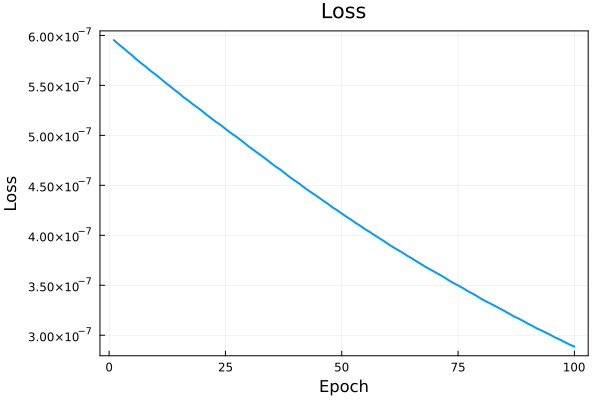

In [30]:
plot(loss_train, legend=nothing, framestyle=:box, linewidth=2, title="Loss")
ylabel!("Loss")
xlabel!("Epoch")
#savefig(joinpath(figure_dir, "Loss_50step.png"))

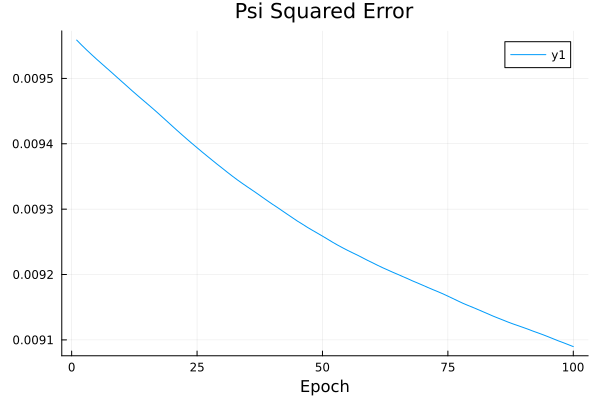

In [31]:
phi_dif = map(i -> (k_phi_estimated_array[i] - ff_phi_target.k) .^ 2, 1:nepoch) |> cpu
psi_dif = map(i -> (k_psi_estimated_array[i] - ff_psi_target.k) .^ 2, 1:nepoch) |> cpu

#二乗誤差
phi_squared_error = map(x -> sum(x), phi_dif)
psi_squared_error = map(x -> sum(x), psi_dif)

phi_dif = [[phi_dif[j][i] for j in 1:nepoch] for i in 1:size(ff_phi_target.k, 1)]
psi_dif = [[psi_dif[j][i] for j in 1:nepoch] for i in 1:size(ff_psi_target.k, 1)]

plot(phi_squared_error, xlabel="Epoch", title="Psi Squared Error")

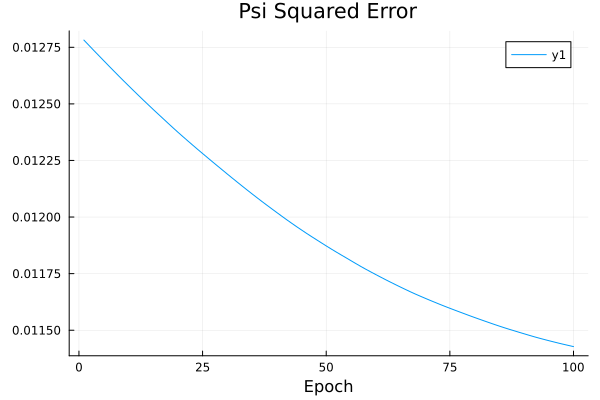

In [32]:
plot(psi_squared_error, xlabel="Epoch", title="Psi Squared Error")

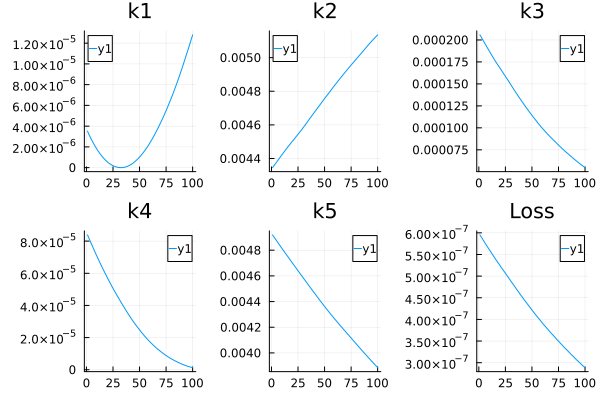

In [33]:
#k_phiと正解の二乗誤差
plt = []
for i in 1:size(ff_phi_target.k, 1)
    tmp = plot()
    plot!(tmp, phi_dif[i], title="k$i")
    push!(plt, tmp)
end
tmp = plot()
plot!(tmp, loss_train, title="Loss")
push!(plt, tmp)

plot(plt...)

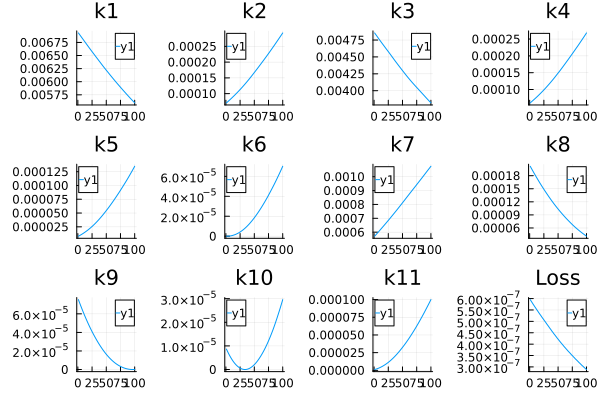

In [34]:
#k_psiと正解の二乗誤差
plt = []
for i in 1:size(ff_psi_target.k, 1)
    tmp = plot()
    plot!(tmp, psi_dif[i], title="k$i")
    push!(plt, tmp)
end
tmp = plot()
plot!(tmp, loss_train, title="Loss")
push!(plt, tmp)

plot(plt...)